In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric as tgn
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
import torch.nn.functional as F

from torch_geometric.loader import DataLoader

from tqdm import tqdm

# Model Definitions

In [4]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [5]:
class EdgeConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='max') #  "Max" aggregation.
        self.mlp = Seq(Linear(2 * in_channels, out_channels),
                       ReLU(),
                       Linear(out_channels, out_channels))

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        # x_i has shape [E, in_channels]
        # x_j has shape [E, in_channels]

        tmp = torch.cat([x_i, x_j - x_i], dim=1)  # tmp has shape [E, 2 * in_channels]
        return self.mlp(tmp)

# Training and Helper Methods

In [22]:
def train_one_epoch(model, data_loader, optimizer, loss_fn):
    
    for _, batch in enumerate(data_loader):
        optimizer.zero_grad()
        model_out = model(batch.x.float(), batch.edge_index)
        loss = loss_fn(torch.squeeze(model_out), batch.y.float())
        loss.backward()  
        optimizer.step()
    
    return loss
    

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Message Passing Pyg Experiments

In [42]:
data_list = torch.load('tensor_list.pt')

# data_list = torch.load('tensor_list_node_labels.pt')

In [43]:
# we are labelling every node with the graph label
data_list[0].y

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], dtype=torch.float64)

In [44]:
loader = DataLoader(data_list, batch_size=32)

In [45]:
model = GCNConv(2,1)
print('num model params:', count_parameters(model))
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

num model params: 3


### Train

In [46]:
epochs = 2000

model.train()

losses = []
pbar = tqdm(total = epochs, position=0, leave=True)
for epoch in range(epochs):
    losses.append(train_one_epoch(model, loader, optimizer, loss_fn))
    pbar.update(1)
pbar.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [13:40<00:00,  2.49it/s]

<bound method tqdm.close of <tqdm.std.tqdm object at 0x7f8f34381ca0>>

In [47]:
adam_optim_GCN_losses = losses

In [48]:
loader = DataLoader(data_list, batch_size=32)

In [49]:
model = GCNConv(2,1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

In [50]:
epochs = 2000

model.train()

losses = []
pbar = tqdm(total = epochs, position=0, leave=True)
for epoch in range(epochs):
    losses.append(train_one_epoch(model, loader, optimizer, loss_fn))
    pbar.update(1)
pbar.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [12:47<00:00,  2.65it/s]

<bound method tqdm.close of <tqdm.std.tqdm object at 0x7f8f3437ba60>>

In [51]:
sgd_optim_GCN_losses = losses

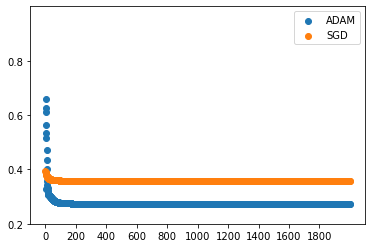

In [79]:
epochs = len(sgd_optim_GCN_losses)
adam_y = [item.detach().numpy() for item in adam_optim_GCN_losses]
sgd_y = [item.detach().numpy() for item in sgd_optim_GCN_losses]


plt.scatter(range(epochs), adam_y, label='ADAM')
plt.scatter(range(epochs), sgd_y, label='SGD')

plt.yticks(np.arange(start=0, stop=1, step=0.2))
plt.xticks(np.arange(start=0, stop=2000, step=200))
plt.ylim(0.2, 1.0)

plt.legend()

### EdgeConv

In [71]:
model = EdgeConv(2,2)
print('num model params:', count_parameters(model))
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

num model params: 16


In [72]:
epochs = 100

model.train()
for epoch in range(epochs):
    train_one_epoch(model, loader, optimizer, loss_fn)

/Users/maxperozek/opt/anaconda3/envs/comp_gr_thy/lib/python3.9/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([818, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (2) must match the size of tensor b (32) at non-singleton dimension 1

In [63]:
from torch.nn import Softmax

In [65]:
m = Softmax(dim=1)
inp = torch.randn(2, 3)
output = m(inp)

In [66]:
output

tensor([[0.6567, 0.1431, 0.2002],
        [0.1342, 0.6416, 0.2242]])

In [67]:
inp

tensor([[ 0.2658, -1.2583, -0.9221],
        [ 0.8187,  2.3836,  1.3323]])